<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/mask_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model evaluation (inference) on COCO 2017 dataset

The following models will be evaluated:

| Model | Backbone | Image Size | Parameters | GFLOPs
| --- | --- | --- | --- | --- |
| YOLOv5s |  Custom | 640x640 | 7.3M | 17 |
| YOLOv5m |  Custom | 640x640 | 21.4M | 51.3 |
| YOLOv5l |  Custom |640x640 | 47M | 115.5 |
| YOLOv3-tiny |  Darknet53 | 640x640 | 8.8M | 13.3 |

<br>

**Note: GPU Runtime needed**

*Example experiment: Tesla K80, 460.32.03, 11441 MiB, batch_size=8, workers=2*

In [ ]:
# Show system specs
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB


### Inference Parameters

In [10]:
# Parameters
load_ckpt_path = '/content/drive/MyDrive/object-detection-checkpoints/pretrained/PWMDD_yolov3_tiny_sgd_ep50_lr01_run/weights/last.pt'  # Model checkpoint to load

dataset_name = 'PWMDD'  # Dataset to evaluate: 'MASKD' or 'PWMDD'

num_workers = 2  #  Data loader workers
batch_size = 1  # Data loader batch size

th = 0  # Threshold for confidence score of predicted bboxes to show

### Get requirements
*Note: Restart runtime after installation*

In [2]:
%%shell

# Install Yolov5
cd /content
git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install --quiet -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 9249, done.
remote: Total 9249 (delta 0), reused 0 (delta 0), pack-reused 9249
Receiving objects: 100% (9249/9249), 9.82 MiB | 24.58 MiB/s, done.
Resolving deltas: 100% (6417/6417), done.
     |████████████████████████████████| 636 kB 5.1 MB/s 


In [3]:
%%shell

# Install Yolov3
cd /content
git clone https://github.com/ultralytics/yolov3
cd yolov3
pip install --quiet -r requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 9862, done.
remote: Total 9862 (delta 0), reused 0 (delta 0), pack-reused 9862
Receiving objects: 100% (9862/9862), 9.19 MiB | 26.37 MiB/s, done.
Resolving deltas: 100% (6667/6667), done.


In [4]:
%%shell

# Install flops-counter
pip install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.6-py3-none-any.whl size=8903 sha256=7236489e2f3fb3a034f919ce15b9ce8621e28bdf9e142764916a037332194561
  Stored in directory: /root/.cache/pip/wheels/eb/7c/e5/2332373fcac1b39ba9eb95698ac370da3e14eaba5516e22721
Successfully built ptflops


In [5]:
%%shell

# Clone asset files
cd /content
git clone https://github.com/joangog/object-detection-assets
cd object-detection-assets
mv -n scripts ../
rm -rf /content/object-detection-assets/

Cloning into 'object-detection-assets'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 87 (delta 26), reused 73 (delta 15), pack-reused 0
Unpacking objects: 100% (87/87), done.


### Import packages

In [2]:
from google.colab import files
from google.colab import drive
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow

import os, sys
import math
import time
import copy
import re
import io

import numpy as np
import pandas as pd
import json
import xml.etree.ElementTree as ET
import html

import PIL
import cv2
import IPython
from IPython.display import display, Javascript, Image
from base64 import b64decode, b64encode

import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

from pycocotools import coco
from pycocotools import mask as cocomask

from ptflops import get_model_complexity_info

import scripts.utils as SU
import scripts.transforms as ST
import scripts.engine as SE
import scripts.coco_utils as SCU
from scripts.coco_eval import CocoEvaluator

### Define auxiliary functions

In [3]:
def add_motion_blur(img, kernel_size, kernel_angle):
  kernel = np.zeros((kernel_size, kernel_size))
  if kernel_angle == 'v':  # Vertical Motion Blur
    kernel[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
  elif kernel_angle == 'h':  # Horizontal Motion Blur
    kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
  kernel /= kernel_size
  return cv2.filter2D(img, -1, kernel)

# Converts base64 image from JS reply to PIL image
def js_to_image(js_reply):  
  image_bytes = b64decode(js_reply.split(',')[1])
  img = PIL.Image.open(io.BytesIO(image_bytes))
  return img

# Convert OpenCV Rectangle bbox overlay image into base64 byte string
def bbox_to_bytes(bbox_array):
  # Convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # Format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # Format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
  return bbox_bytes

# JavaScript code to print live video stream using webcam
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

### Connect to GDrive for storage access

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


### Download Mask dataset

In [60]:
%%shell

cd /content
mkdir -p dataset
cd /content/dataset
mkdir -p images annotations
cd /content/dataset/images
mkdir -p val_images

In [61]:
!cd /content

if dataset_name == 'MASKD':

  # Download validation images
  !gdown --id '101F2k6PJ-tD_uwlsCG7zzGF9ILJW01M1'
  !unzip -q -n 'val_images.zip' -d '/content/dataset/images/'

  # Download validation annotations
  !gdown -O '/content/dataset/annotations/val.json' --id '1YLV7-7vmiNdFI8Xpdx_jbhnxfgQRWrgF'

elif dataset_name == 'PWMDD':

  # Download validation images
  !gdown -O val_images.rar --id  1ZXuSwoRvTnnca81RUj3kMoLFZJ6auAwT
  !unrar e -idq -o- 'val_images.rar' '/content/dataset/images/val_images'

  # Convert annotation files from PASCAL VOC .xml to COCO .json (only for PWMDD dataset)

  images_dir = '/content/dataset/images'
  anns_dir = '/content/dataset/annotations'
  label_ids = {'with_mask': 1, 'without_mask': 2, 'incorrect_mask': 3}  # BG class is 0
  ann_count = 0  # Annotation counter

  images = []
  annotations = []
  
  val_images_dir = os.path.join(images_dir,'val_images')

  xml_files = os.listdir(val_images_dir)
  xml_files = [file for file in xml_files if '.xml' in file]

  for xml_file in xml_files:

    tree = ET.parse(os.path.join(val_images_dir,xml_file))
    root = tree.getroot()

    # Image
    file_name = root[0].text
    height = int(root[1][1].text)
    width = int(root[1][0].text)
    id = int(re.sub(r'^\D*0*', '', file_name).replace('.jpg',''))  # Remove preceding zeros and file format
    images.append(
        {
          'file_name': file_name,
          'height': height,
          'width': width,
          'id': id
        }
    )
    
    # Annotations
    if len(root) > 2:  # If annotations (object attribute) exist, they will be after the 1-index attribute in the XML
      for i in range(2,len(root)):
        category_id = label_ids[root[i][0].text]
        xmin = int(root[i][1][0].text)
        ymin = int(root[i][1][1].text)
        xmax = int(root[i][1][2].text)
        ymax = int(root[i][1][3].text)
        annotations.append(
            {
              'iscrowd': 0,
              'image_id': id,
              'bbox': [xmin, ymin, xmax-xmin, ymax-ymin],
              'area': (xmax-xmin) * (ymax-ymin),
              'category_id': category_id,
              'ignore': 0,
              'id': ann_count,
              'segmentation': []
            }
        )
        ann_count += 1

  coco_dict = {
  'info': {},
  'images': images,
  'annotations': annotations,
  'licenses': []
  }

  with open(os.path.join(anns_dir,f'{type_images}.json'),'w') as outfile:
    json.dump(coco_dict, outfile, indent=3)

# Copy annotations in images folder
!cp '/content/dataset/annotations/val.json' '/content/dataset/images/val_images'

Downloading...
From: https://drive.google.com/uc?id=1ZXuSwoRvTnnca81RUj3kMoLFZJ6auAwT
To: /content/val_images.rar
204MB [00:02, 90.1MB/s]


### Load Mask dataset

In [62]:
val_img_dir = '/content/dataset/images/val_images'
val_ann_file = 'val.json'  # annotations
val_ann_path = os.path.join(val_img_dir,val_ann_file)  

# Define data transforms
transforms = ST.Compose([ST.ToTensor()])

# Create datasets
val_dataset = CocoDetection(val_img_dir, val_ann_path, transforms = transforms)

# Create data loaders
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)

# Get label names
if dataset_name == 'MASKD':
  label_ids = [1,2]
  label_names = ['mask', 'no_mask']
elif dataset_name == 'PWMDD':
  label_ids = [1,2,3]
  label_names = ['with_mask', 'without_mask', 'incorrect_mask']
labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value
label_colors = {1: (0,255,0), 2:(255,0,0), 3: (255,255,0)}

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


### Load model

In [12]:
%cd /content

# Delete utils package to reload it (if loaded), because YOLOv3 and YOLOv5 have
# the same name for it and it causes error
try:
  sys.modules.pop('utils')
except:
  pass

# @markdown Model Selection { display-mode: 'form', run: 'auto' }
model_name = 'YOLOv3-tiny' # @param ['SSD300 VGG16', 'SSDlite320 MobileNetV3-Large', 'Faster R-CNN ResNet-50 FPN', 'Faster R-CNN MobileNetV3-Large FPN', 'Mask R-CNN ResNet-50 FPN', 'YOLOv5s', 'YOLOv5m', 'YOLOv5l', 'YOLOv3', 'YOLOv3-tiny', 'YOLOv3-spp']

# @markdown *Note: If you get the error "Cache may be out of date, try 'force_reload=True'" then restart runtime.*

if model_name == 'SSD300 VGG16':
  model_id = 'ssd300_vgg16'
  model = M.ssd300_vgg16(pretrained=False, progress=True)
  model_img_size = (3,300,300)
elif model_name == 'SSDlite320 MobileNetV3-Large':
  model_id = 'ssdlite320_mobilenet_v3_large'
  model = M.ssdlite320_mobilenet_v3_large(pretrained=False, progress=True)
  model_img_size = (3,320,320)
elif model_name == 'Faster R-CNN ResNet-50 FPN':
  model_id = 'fasterrcnn_resnet50_fpn'
  model = M.fasterrcnn_resnet50_fpn(pretrained=False, progress=True)
  model_img_size = (3,800,800) # COCO's 640x640 in upscaled to the model's minimum 800x800
elif model_name == 'Faster R-CNN MobileNetV3-Large FPN':
  model_id = 'fasterrcnn_mobilenet_v3_large_fpn'
  model = M.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False, progress=True)
  model_img_size = (3,800,800) 
elif model_name == 'Mask R-CNN ResNet-50 FPN':
  model_id = 'maskrcnn_resnet50_fpn'
  model = M.maskrcnn_resnet50_fpn(pretrained=False, progress=True)
  model_img_size = (3,800,800)
elif 'YOLOv5' in model_name:
  model_id = model_name.lower().replace('-','_')
  model = torch.hub.load('/content/yolov5', 'custom', path=load_ckpt_path, source='local', force_reload=True)
  model_img_size = (3,640,640)
elif 'YOLOv3' in model_name:
  model_id = model_name.lower().replace('-','_')
  model = torch.hub.load('/content/yolov3', 'custom', path=load_ckpt_path, source='local', force_reload=True)
  model_img_size = (3,640,640)

# Prepare model for dataset (for Fast R-CNN or Mask R-CNN)
if 'R-CNN' in model_name: 
  num_classes = len(val_dataset.coco.getCatIds()) + 1
  # Get the number of input features for the bbox predictor
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # Replace the pre-trained head with a new one
  model.roi_heads.box_predictor = M.faster_rcnn.FastRCNNPredictor(in_features, num_classes)  # includes background (0) class
  if 'Mask R-CNN' in model_name:
    # Get the number of input features for the segmentation max predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = M.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer,num_classes)

print('-------------------------------------------------------------------------------------------------------\n')

print(f'Loaded model: {model_name}')
model_params = round(sum([param.numel() for param in model.parameters()]) / 1000000, 1)
print(f'\t- Parameters: {model_params}M')
model_macs, _ = get_model_complexity_info(model, model_img_size, as_strings=False, 
                                          print_per_layer_stat=False, verbose=False)
model_gflops = round(2 * int(model_macs) / 1000000000, 1)
print(f'\t- GFLOPs: {model_gflops}')

Fusing layers... 


/content


Model Summary: 48 layers, 8671312 parameters, 0 gradients, 12.9 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 v5.0-466-gc5ba2ab torch 1.9.0+cu102 CPU



-------------------------------------------------------------------------------------------------------

Loaded model: YOLOv3-tiny
	- Parameters: 8.7M
	- GFLOPs: 13.0


### (Optional) Test model with image sample
*Note 1: If you get the error "module 'PIL.TiffTags' has no attribute 'IFD'" then restart runtime.*


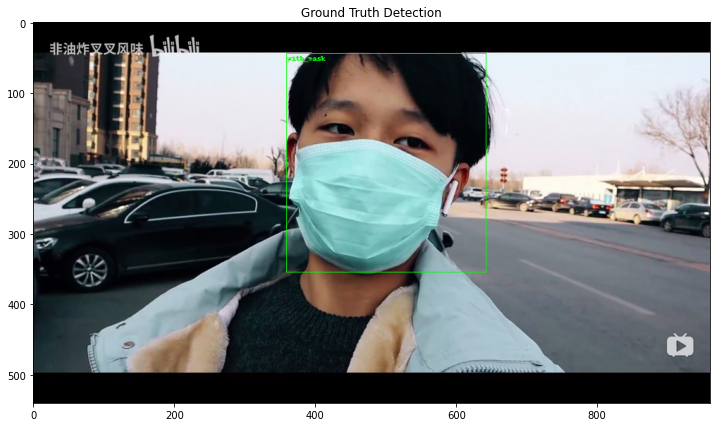

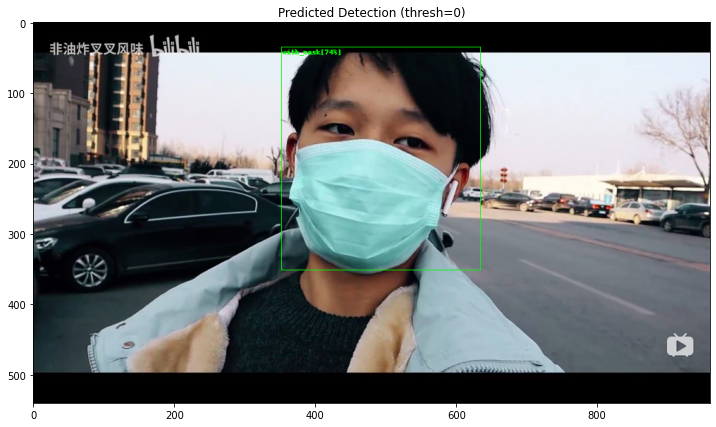

In [69]:
%matplotlib inline

# Parameters
img_from_path = False
img_path = '/content/test.jpg'  # Only for image from path
img_id = 27  # Only for image not from path (image from val dataset)

# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get image sample
if img_from_path:
  img = cv2.imread(img_path)
else:
  img = cv2.imread(os.path.join(val_img_dir,val_dataset.coco.loadImgs([img_id])[0]['file_name']))

img = PIL.Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Format image
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor,255).float().to(device)  # Format image for torchvision models
img_anns = val_dataset.coco.loadAnns(val_dataset.coco.getAnnIds([img_id]))

# Draw ground truth bboxes
if not img_from_path:  # If the image is not from path (if it is, ground truth doesn't exist)
  true_bboxes = SE.convert_to_xyxy(copy.deepcopy(F.Tensor([obj['bbox'] for obj in img_anns]).to(device)))  # Create deep copy to avoid updating original dataset
  true_labels = [labels[obj['category_id']] for obj in img_anns]
  true_img = U.draw_bounding_boxes(img_tensor, true_bboxes, true_labels, colors=[label_colors[obj['category_id']] for obj in img_anns])
  plt.figure(figsize = (25,7))
  plt.title('Ground Truth Detection')
  plot = plt.imshow(F.to_pil_image(true_img))

# Generate model predictions
model.eval()
with torch.no_grad():
  if 'YOLO' in model_name:
    pred = model([img])
  else:    
    pred = model([img_torchvision])

# Get predicted bboxes
# For YOLO models
if 'YOLO' in model_name:  
  pred_bboxes = []
  pred_label_ids = []
  pred_labels = []
  for bbox in pred.xyxy[0]:  # For every bbox
    conf = bbox[4]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox[:4])
      label_id = labels_inv[label_names[int(bbox[5])]]  # Convert YOLO label id to COCO label id
      pred_label_ids.append(label_id)  
      pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)

# For torchvision models
else:
  for i, bbox in enumerate(pred[0]['boxes']):  # For every bbox
    conf = pred[0]['scores'][i]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox)
      label_id = pred[0]['labels'][i]
      pred_label_ids.append(label_id)
      pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)

# Draw predicted bboxes
if len(pred_bboxes) != 0:
  pred_img = U.draw_bounding_boxes(img_tensor, pred_bboxes, pred_labels, colors=[label_colors[label_id] for label_id in pred_label_ids])
else:  # If no bboxes are found just return the image
  pred_img = img_tensor
plt.figure(figsize = (25,7))
plt.title(f'Predicted Detection (thresh={th})')
plot = plt.imshow(F.to_pil_image(pred_img))

### Test model on webcam video stream

In [ ]:
# Start streaming video from webcam
video_stream()

# Label for video
label_html = 'Capturing...'

# Initialze bounding box to empty
bbox = ''
count = 0 

while True:
    
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convert JS response to PIL Image
    frame = js_to_image(js_reply["img"])
    plt.imshow(frame)

    # Create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # Format frame (for torchvision models)
    frame_tensor = F.convert_image_dtype(F.to_tensor(frame),torch.uint8)
    frame_torchvision = torch.div(frame_tensor,255).float().to(device)

    # Generate model predictions
    model.eval()
    with torch.no_grad():
      if 'YOLO' in model_name:
        pred = model(frame)
      else:    
        pred = model([frame_torchvision])

    # Get predicted bboxes
    # For YOLO models
    if 'YOLO' in model_name:  
      pred_bboxes = []
      pred_label_ids = []
      pred_labels = []
      for img in pred.xyxy: # For every image
        for bbox in img:  # For every bbox of that image
          conf = bbox[4]
          if conf > th:  # Show only bboxes with high confidence score
            pred_bboxes.append(bbox[:4])
            label_id = labels_inv[label_names[int(bbox[5])]]  # Convert YOLO label id to COCO label id
            pred_label_ids.append(label_id)  
            pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
      if len(pred_bboxes) != 0:
        pred_bboxes = torch.stack(pred_bboxes)
    # For torchvision models
    else:
      for i, bbox in enumerate(pred[0]['boxes']):  # For every bbox
        conf = pred[0]['scores'][i]
        if conf > th:  # Show only bboxes with high confidence score
          pred_bboxes.append(bbox)
          label_id = pred[0]['labels'][i]
          pred_label_ids.append(label_id)
          pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
      if len(pred_bboxes) != 0:
        pred_bboxes = torch.stack(pred_bboxes)  

    predictions = zip(pred_label_ids, pred_labels, pred_bboxes)

    # Loop through detections and draw them on transparent overlay image
    for label_id, label, bbox in predictions:
      left, top, right, bottom = bbox
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), label_colors[label_id], 2)
      bbox_array = cv2.putText(bbox_array, "{}".format(label),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        label_colors[label_id], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes